# Air Quality Prediction

[World's Air Pollution: Real-Time Air Quality Index](https://waqi.info/)

https://aqicn.org/json-api/doc/

## Prepare environment

In [49]:
import pandas as pd
import numpy as np
import holidays
from meteostat import Point, Daily
from datetime import datetime
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.signal import periodogram
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import random
import xgboost as xgb
from sklearn.multioutput import MultiOutputRegressor

np.random.seed(42)
random.seed(42)

## Configuration

In [50]:
# Let's first keep X window and y window same size
historical_window_size = 3
prediction_window_size = 3

## Prepare data

### Load data

In [51]:
aqi_pd = pd.read_csv("../data/air_quality_history.csv", skipinitialspace=True)

In [52]:
# Make sure column names are stripped
aqi_pd.columns

Index(['date', 'pm25', 'pm10', 'no2', 'so2', 'co'], dtype='object')

In [53]:
aqi_pd["date"] = pd.to_datetime(aqi_pd["date"], format="%Y/%m/%d")

In [54]:
aqi_pd = aqi_pd.set_index("date")

In [55]:
aqi_pd.head()

,pm25,pm10,no2,so2,co
date,,,,,
2025-07-01,28.0,12.0,3.0,1.0,5.0
2025-07-02,41.0,22.0,7.0,1.0,5.0
2025-07-03,65.0,16.0,3.0,NaN,5.0
2025-07-04,42.0,12.0,3.0,1.0,5.0
2025-07-05,41.0,14.0,2.0,1.0,5.0


In [56]:
aqi_pd.describe(percentiles=[0.25, 0.5, 0.75, 0.9, 0.95])

,pm25,pm10,no2,so2,co
count,1300.000000,1301.000000,1292.000000,1205.000000,1294.000000
mean,44.866923,15.099923,5.592105,3.140249,3.980680
std,18.238856,7.775752,3.761483,1.698959,1.555003
min,10.000000,2.000000,1.000000,1.000000,1.000000
25%,31.000000,10.000000,3.000000,2.000000,3.000000
50%,43.500000,14.000000,5.000000,3.000000,4.000000
75%,56.000000,19.000000,7.000000,4.000000,5.000000
90%,68.000000,25.000000,11.000000,5.000000,6.000000
95%,76.000000,29.000000,13.000000,6.000000,7.000000
max,117.000000,90.000000,27.000000,15.000000,12.000000


### Handle missing dates

In [57]:
full_range = pd.date_range(start=aqi_pd.index.min(), end=aqi_pd.index.max(), freq="D")

# Check for missing dates
full_range.difference(aqi_pd.index)

DatetimeIndex(['2024-12-30'], dtype='datetime64[ns]', freq='D')

In [58]:
aqi_pd.loc[pd.Timestamp("2024-12-30")] = aqi_pd.loc[pd.Timestamp("2024-12-31")]
aqi_pd = aqi_pd.sort_index()

In [59]:
full_range.difference(aqi_pd.index)

DatetimeIndex([], dtype='datetime64[ns]', freq='D')

### Handle N/A values

In [60]:
aqi_pd.isna().sum()

pm25     3
pm10     1
no2     10
so2     97
co       8
dtype: int64

In [61]:
aqi_pd = aqi_pd.fillna(aqi_pd.median())

In [62]:
aqi_pd.isna().sum()

pm25    0
pm10    0
no2     0
so2     0
co      0
dtype: int64

## Feature engineering

### Calendar Features

In [63]:
svk_holidays = holidays.Slovakia()

datetime_pd = aqi_pd.index

aqi_pd["year"] = datetime_pd.year
aqi_pd["month"] = datetime_pd.month
aqi_pd["day_of_month"] = datetime_pd.day
aqi_pd["day_of_week"] = datetime_pd.dayofweek
aqi_pd["day_of_year"] = datetime_pd.dayofyear
aqi_pd["week_of_year"] = datetime_pd.isocalendar().week
aqi_pd["is_leap_year"] = datetime_pd.is_leap_year.astype(int)
aqi_pd["is_working_day"] = [int(svk_holidays.is_working_day(x)) for x in datetime_pd]
aqi_pd["is_feb29"] = ((aqi_pd["month"] == 2) & (aqi_pd["day_of_month"] == 29)).astype(int)

### Cyclical features

TODO: 
For cyclical features (month, day_of_week, hour, day_of_year), it's often better to transform them
into sine and cosine components to preserve the cyclical nature and avoid arbitrary ordinal relationships.

### Meteorological data

[Meteorological Parameters](https://dev.meteostat.net/formats.html#meteorological-parameters)

In [64]:
# Define Poprad coordinates
# Coordinates of Poprad-Tatry Airport (LZTT) meteo station.
location = Point(49.07, 20.24, 718)  # Lat, Lon, Elevation (optional but good)

start_date = datetime_pd.min()
end_date = datetime_pd.max()

daily_weather = Daily(location, start_date, end_date)
weather_pd = daily_weather.fetch()

print(weather_pd.head())

            tavg  tmin  tmax  prcp  snow  wdir  wspd  wpgt    pres  tsun
time                                                                    
2021-12-27 -13.1 -17.2  -8.0  <NA>  <NA>  <NA>   2.7  13.0  1009.1  <NA>
2021-12-28  -9.3 -13.8  -2.0  <NA>  <NA>  <NA>   4.0  13.0  1006.6  <NA>
2021-12-29  -4.1  -8.1  -0.9  <NA>  <NA>  <NA>   4.8  14.8  1005.6  <NA>
2021-12-30  -3.6  -9.6   1.8  <NA>  <NA>  <NA>   4.7  13.0  1015.0  <NA>
2021-12-31   3.9  -0.2   8.2  <NA>  <NA>  <NA>  15.2  33.3  1017.1  <NA>


In [65]:
weather_pd.describe()

,tavg,tmin,tmax,prcp,snow,wdir,wspd,wpgt,pres,tsun
count,1303.0,1303.0,1303.0,1168.0,4.0,0.0,1303.0,1292.0,1303.0,0.0
mean,7.873062,2.58749,13.147276,2.109332,2.0,<NA>,12.478511,26.593111,1016.221182,<NA>
std,7.986217,7.360569,9.126794,4.386507,1.414214,<NA>,6.629821,9.283313,7.993424,<NA>
min,-13.1,-20.2,-8.0,0.0,1.0,<NA>,2.6,11.1,987.5,<NA>
25%,1.2,-3.0,6.0,0.0,1.0,<NA>,7.8,20.4,1011.6,<NA>
50%,7.7,2.9,13.1,0.1,1.5,<NA>,10.5,24.1,1016.8,<NA>
75%,14.65,8.6,20.85,2.1,2.5,<NA>,15.3,31.5,1021.2,<NA>
max,24.5,18.4,34.0,42.7,4.0,<NA>,47.8,57.4,1039.8,<NA>


In [66]:
# No data available for these features from selected meteo station
weather_pd.drop(["wdir", "tsun"], axis=1, inplace=True)

In [67]:
weather_pd.isna().sum()

tavg       0
tmin       0
tmax       0
prcp     135
snow    1299
wspd       0
wpgt      11
pres       0
dtype: int64

In [68]:
# N/A here means that there was no rain or snow - so filling with 0 instead
weather_pd["prcp"] = weather_pd["prcp"].fillna(0.0)
weather_pd["snow"] = weather_pd["snow"].fillna(0.0)

# Let's assume that rest N/A is just missing reading, and fill with median
weather_pd.fillna(weather_pd.median(), inplace=True)

In [69]:
weather_pd.isna().sum()

tavg    0
tmin    0
tmax    0
prcp    0
snow    0
wspd    0
wpgt    0
pres    0
dtype: int64

In [70]:
merged_df = pd.merge_asof(aqi_pd, weather_pd, left_index=True, right_index=True)

In [71]:
merged_df.head()

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
date,,,,,,,,,,,,,,,,,,,,,
2021-12-27,43.5,37.0,25.0,2.0,12.0,2021,12,27,0,361,...,1,0,-13.1,-17.2,-8.0,0.0,0.0,2.7,13.0,1009.1
2021-12-28,105.0,36.0,21.0,3.0,9.0,2021,12,28,1,362,...,1,0,-9.3,-13.8,-2.0,0.0,0.0,4.0,13.0,1006.6
2021-12-29,104.0,26.0,17.0,1.0,10.0,2021,12,29,2,363,...,1,0,-4.1,-8.1,-0.9,0.0,0.0,4.8,14.8,1005.6
2021-12-30,73.0,17.0,8.0,1.0,9.0,2021,12,30,3,364,...,1,0,-3.6,-9.6,1.8,0.0,0.0,4.7,13.0,1015.0
2021-12-31,56.0,6.0,5.0,1.0,12.0,2021,12,31,4,365,...,1,0,3.9,-0.2,8.2,0.0,0.0,15.2,33.3,1017.1


In [72]:
merged_df.columns

Index(['pm25', 'pm10', 'no2', 'so2', 'co', 'year', 'month', 'day_of_month',
       'day_of_week', 'day_of_year', 'week_of_year', 'is_leap_year',
       'is_working_day', 'is_feb29', 'tavg', 'tmin', 'tmax', 'prcp', 'snow',
       'wspd', 'wpgt', 'pres'],
      dtype='object')

### Convert all features to float

Converting all features to floats is a fundamental preprocessing step for neural networks. It ensures compatibility with the underlying mathematical operations, facilitates normalization, and aligns with the requirements of deep learning frameworks.

In [73]:
merged_df = merged_df.astype(float)

In [74]:
merged_df.dtypes

pm25              float64
pm10              float64
no2               float64
so2               float64
co                float64
year              float64
month             float64
day_of_month      float64
day_of_week       float64
day_of_year       float64
week_of_year      float64
is_leap_year      float64
is_working_day    float64
is_feb29          float64
tavg              float64
tmin              float64
tmax              float64
prcp              float64
snow              float64
wspd              float64
wpgt              float64
pres              float64
dtype: object

## Explore trends

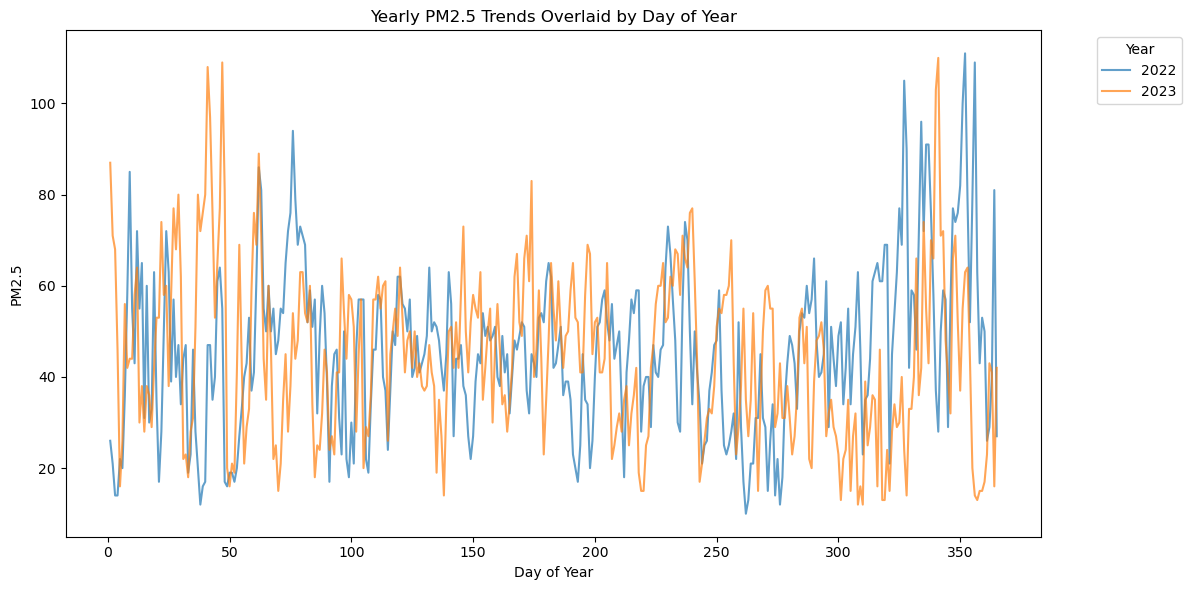

In [75]:
plt.figure(figsize=(12, 6))
for year, group in aqi_pd.groupby("year"):
    if (year in [2022, 2023]):
        plt.plot(group["day_of_year"], group["pm25"], label=str(year), alpha=0.7)

plt.xlabel("Day of Year")
plt.ylabel("PM2.5")
plt.title("Yearly PM2.5 Trends Overlaid by Day of Year")
plt.legend(title="Year", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


<Figure size 1000x500 with 0 Axes>

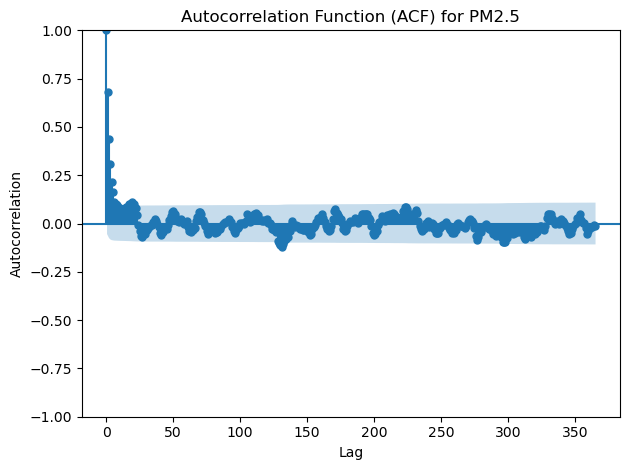

In [76]:
plt.figure(figsize=(10, 5))
plot_acf(aqi_pd["pm25"], lags=365)
plt.title("Autocorrelation Function (ACF) for PM2.5")
plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.tight_layout()
plt.show()

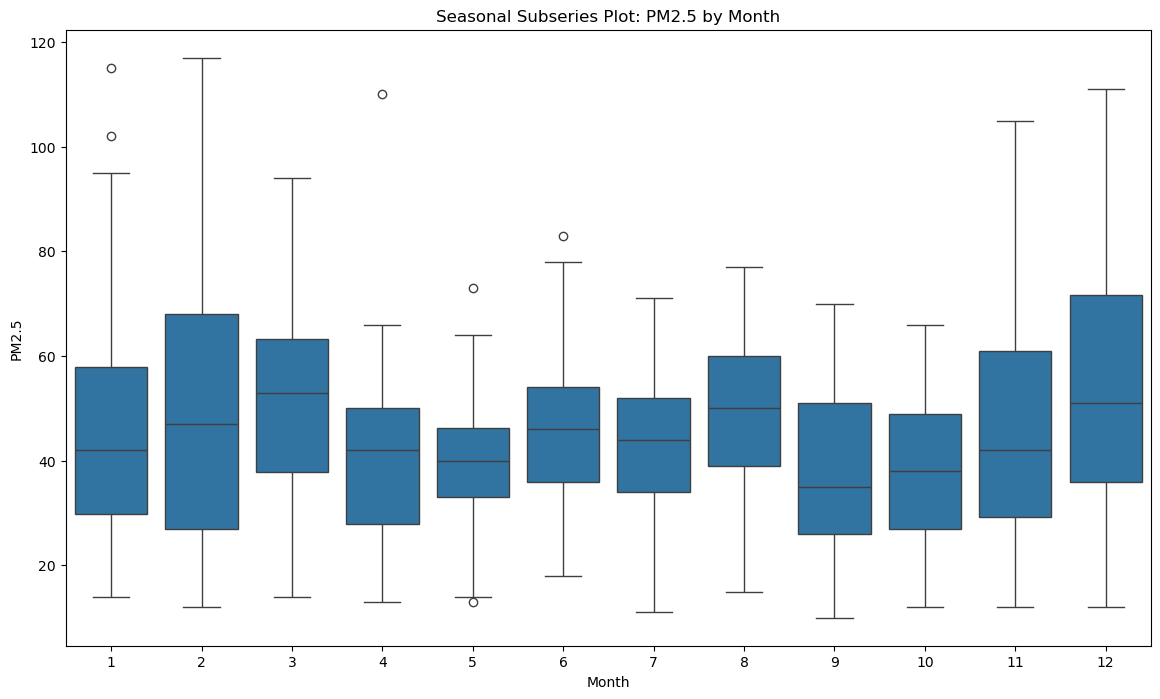

In [77]:
plt.figure(figsize=(14, 8))
sns.boxplot(x="month", y="pm25", data=aqi_pd)
plt.title("Seasonal Subseries Plot: PM2.5 by Month")
plt.xlabel("Month")
plt.ylabel("PM2.5")
plt.show()

<Figure size 1400x1000 with 0 Axes>

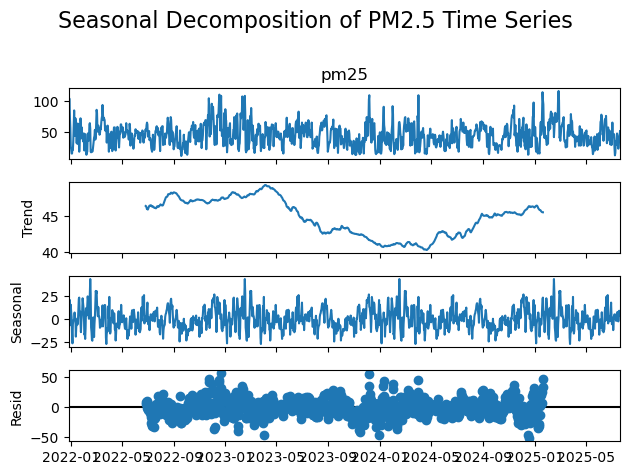

In [78]:
# Ensure pm25 is float and has no missing values for decomposition
pm25_series = aqi_pd["pm25"].astype(float).interpolate()

result = seasonal_decompose(pm25_series, model='additive', period=365)

plt.figure(figsize=(14, 10))
result.plot()
plt.suptitle("Seasonal Decomposition of PM2.5 Time Series", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

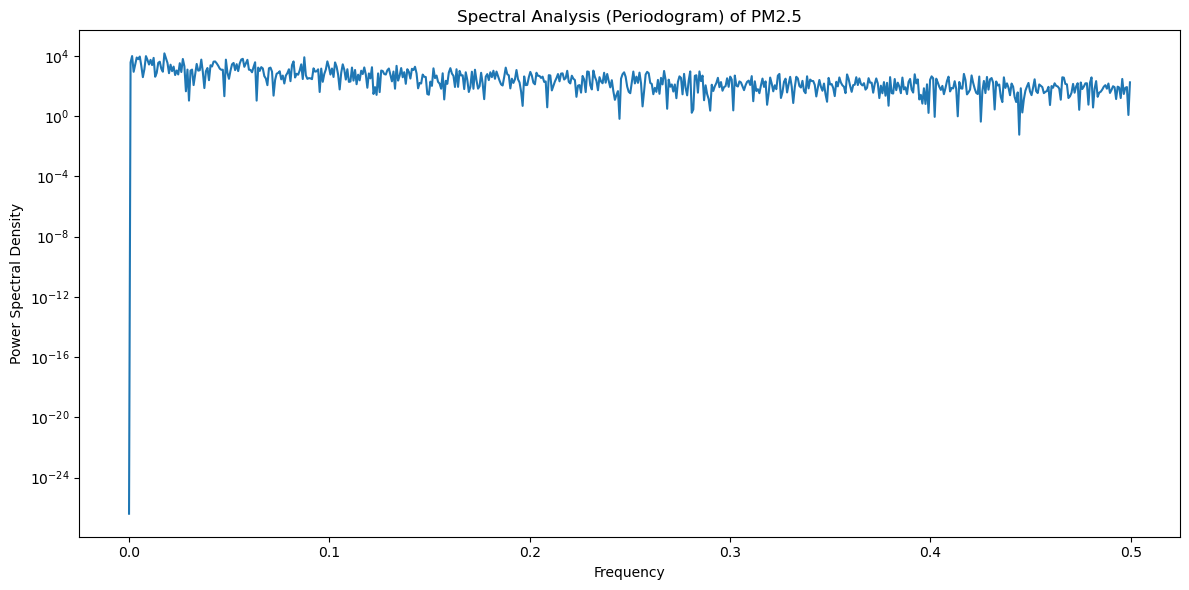

In [79]:
# Fill missing values in pm25 for spectral analysis
pm25_filled = aqi_pd["pm25"].astype(float).values

# Compute the periodogram
freqs, power = periodogram(pm25_filled)

plt.figure(figsize=(12, 6))
plt.semilogy(freqs, power)
plt.title("Spectral Analysis (Periodogram) of PM2.5")
plt.xlabel("Frequency")
plt.ylabel("Power Spectral Density")
plt.tight_layout()
plt.show()

## Split Data into Training, Validation, and Test Sets

In [80]:
train_size = int(len(merged_df) * 0.8)
val_size = int(len(merged_df) * 0.1)

train_df = merged_df.iloc[:train_size]
val_df = merged_df.iloc[train_size : train_size + val_size]
test_df = merged_df.iloc[train_size + val_size :]

## Split to input features and target features

In [81]:
target_columns = ["pm25", "pm10", "no2", "so2", "co"]

# Since lagged target columns are used as input, let's keep whole DataFrame for X
X_train, y_train = train_df, train_df[target_columns]
X_val, y_val = val_df, val_df[target_columns]
X_test, y_test = test_df, test_df[target_columns]

## Feature Scaling

Not strictly required for tree-based models (Random Forest, Gradient Boosting like XGBoost/LightGBM) as they are scale-invariant, but also don't hurt performance of these models.
However, it is a must for Neural Networks.

In [82]:
numerical_features = [
    col
    for col in merged_df.columns
    if col not in ["is_leap_year", "is_feb29", "is_working_day"]
]

X_scaler = StandardScaler()
# Important: Fit the scaler only on the training data and then transform both training and testing data to prevent data leakage.
X_scaler = X_scaler.fit(pd.concat([X_train[numerical_features], X_val[numerical_features]], axis=0))

y_scaler = StandardScaler()
# Important: Fit the scaler only on the training data and then transform both training and testing data to prevent data leakage.
y_scaler = y_scaler.fit(pd.concat([y_train, y_val], axis=0))

In [83]:
X_train.loc[:, numerical_features] = X_scaler.transform(X_train[numerical_features])
X_val.loc[:, numerical_features] = X_scaler.transform(X_val[numerical_features])
X_test.loc[:, numerical_features] = X_scaler.transform(X_test[numerical_features])

y_train.loc[:] = y_scaler.transform(y_train)
y_val.loc[:] = y_scaler.transform(y_val)
y_test.loc[:] = y_scaler.transform(y_test)

A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [84]:
X_train.head()

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
date,,,,,,,,,,,,,,,,,,,,,
2021-12-27,-0.093267,2.714694,5.006849,-0.672340,5.121818,-2.265593,1.618244,1.283388,-1.497126,1.711354,...,1.0,0.0,-2.548410,-2.607809,-2.248365,-0.462073,-0.044664,-1.441955,-1.420293,-0.871053
2021-12-28,3.214228,2.589684,3.964293,-0.082533,3.232570,-2.265593,1.618244,1.396685,-0.997231,1.720556,...,1.0,0.0,-2.077554,-2.153259,-1.596017,-0.462073,-0.044664,-1.248238,-1.420293,-1.174465
2021-12-29,3.160447,1.339588,2.921737,-1.262147,3.862320,-2.265593,1.618244,1.509982,-0.497336,1.729758,...,1.0,0.0,-1.433225,-1.391220,-1.476420,-0.462073,-0.044664,-1.129028,-1.227490,-1.295830
2021-12-30,1.493255,0.214500,0.575986,-1.262147,3.232570,-2.265593,1.618244,1.623279,0.002559,1.738959,...,1.0,0.0,-1.371271,-1.591757,-1.182863,-0.462073,-0.044664,-1.143929,-1.420293,-0.154999
2021-12-31,0.578988,-1.160606,-0.205932,-1.262147,5.121818,-2.265593,1.618244,1.736576,0.502454,1.748161,...,1.0,0.0,-0.441950,-0.335060,-0.487025,-0.462073,-0.044664,0.420707,0.754093,0.099867


In [85]:
y_train[:5]

,pm25,pm10,no2,so2,co
date,,,,,
2021-12-27,-0.093267,2.714694,5.006849,-0.672340,5.121818
2021-12-28,3.214228,2.589684,3.964293,-0.082533,3.232570
2021-12-29,3.160447,1.339588,2.921737,-1.262147,3.862320
2021-12-30,1.493255,0.214500,0.575986,-1.262147,3.232570
2021-12-31,0.578988,-1.160606,-0.205932,-1.262147,5.121818


## Prepare prediction windows

In [86]:
def split_to_windows(X, y, historical_window_size, prediction_window_size):
    original_input_size = X.shape[0]

    X_new = []
    y_new = []
    for i in range(original_input_size - historical_window_size - prediction_window_size + 1):
        X_window = X[i : i + historical_window_size]
        X_new.append(X_window)

        y_window = y[i + historical_window_size : i + historical_window_size + prediction_window_size]
        y_new.append(y_window)
    
    return X_new, y_new

In [87]:
X_window_train, y_window_train = split_to_windows(X_train, y_train, historical_window_size, prediction_window_size)
X_window_val, y_window_val = split_to_windows(X_val, y_val, historical_window_size, prediction_window_size)
X_window_test, y_window_test = split_to_windows(X_test, y_test, historical_window_size, prediction_window_size)

In [88]:
X_window_train[-1]

,pm25,pm10,no2,so2,co,year,month,day_of_month,day_of_week,day_of_year,...,is_working_day,is_feb29,tavg,tmin,tmax,prcp,snow,wspd,wpgt,pres
date,,,,,,,,,,,,,,,,,,,,,
2024-10-28,0.847890,0.339510,0.836625,-0.672340,0.083823,0.950323,1.054875,1.396685,-1.497126,1.168450,...,1.0,0.0,0.115642,0.213073,-0.041254,-0.462073,-0.044664,-0.950212,-1.227490,1.155743
2024-10-29,-0.012596,0.464520,0.575986,-0.082533,0.083823,0.950323,1.054875,1.509982,-0.997231,1.177652,...,1.0,0.0,0.276724,0.226442,0.458879,-0.462073,-0.044664,-0.205147,-1.023977,1.095060
2024-10-30,0.148745,-0.535558,0.054708,-0.672340,-0.545926,0.950323,1.054875,1.623279,-0.497336,1.186854,...,1.0,0.0,0.227160,0.025905,0.350155,-0.462073,-0.044664,-0.994916,-0.434857,1.022241


In [89]:
y_window_train[-1]

,pm25,pm10,no2,so2,co
date,,,,,
2024-10-31,-1.034424,0.214500,0.315347,-0.672340,0.083823
2024-11-01,-0.173937,-0.160529,0.054708,-0.672340,-0.545926
2024-11-02,-0.173937,-0.285538,0.054708,-1.262147,-0.545926


## Training and Evaluation

In [90]:
def flatten_windows(windows):
    return np.array([window.values.flatten() for window in windows])

In [91]:
# Flatten for regressors
X_flat_train, y_flat_train = flatten_windows(X_window_train), flatten_windows(y_window_train)
X_flat_val, y_flat_val = flatten_windows(X_window_val), flatten_windows(y_window_val)
X_flat_test, y_flat_test = flatten_windows(X_window_test), flatten_windows(y_window_test)

### Decision Tree

In [92]:
dt_regressor = DecisionTreeRegressor()
dt_regressor.fit(X_flat_train, y_flat_train)

DecisionTreeRegressor()

In [93]:
y_pred = dt_regressor.predict(X_flat_test)

In [94]:
def evaluate_predictions(y_true, y_pred, window_size):
    n_outputs = y_true.shape[1]

    for window_index in range(window_size):
        print(f"Day {window_index+1}:")
        for output_index in range(n_outputs // window_size):
            i = output_index + window_size * window_index

            print(f"Metrics for Output {output_index+1} ({target_columns[output_index]}):")
            print(f"  MAE: {mean_absolute_error(y_true[:, i], y_pred[:, i]):.4f}")
            print(f"  MSE: {mean_squared_error(y_true[:, i], y_pred[:, i]):.4f}")
            print(f"  RMSE: {np.sqrt(mean_squared_error(y_true[:, i], y_pred[:, i])):.4f}")
            print(f"  R2 Score: {r2_score(y_true[:, i], y_pred[:, i]):.4f}")
            print("-" * 20)

In [95]:
evaluate_predictions(y_true=y_flat_test, y_pred=y_pred, window_size=prediction_window_size)

Day 1:
Metrics for Output 1 (pm25):
  MAE: 0.7644
  MSE: 1.0487
  RMSE: 1.0240
  R2 Score: -0.8462
--------------------
Metrics for Output 2 (pm10):
  MAE: 0.7094
  MSE: 0.8467
  RMSE: 0.9202
  R2 Score: -1.2188
--------------------
Metrics for Output 3 (no2):
  MAE: 0.6909
  MSE: 0.9662
  RMSE: 0.9829
  R2 Score: -2.5611
--------------------
Metrics for Output 4 (so2):
  MAE: 0.5945
  MSE: 0.5494
  RMSE: 0.7412
  R2 Score: -0.8633
--------------------
Metrics for Output 5 (co):
  MAE: 0.7947
  MSE: 0.8530
  RMSE: 0.9236
  R2 Score: -14.9486
--------------------
Day 2:
Metrics for Output 1 (pm25):
  MAE: 0.5945
  MSE: 0.5494
  RMSE: 0.7412
  R2 Score: -0.8633
--------------------
Metrics for Output 2 (pm10):
  MAE: 0.7947
  MSE: 0.8530
  RMSE: 0.9236
  R2 Score: -14.9486
--------------------
Metrics for Output 3 (no2):
  MAE: 0.8464
  MSE: 1.1673
  RMSE: 1.0804
  R2 Score: -1.0578
--------------------
Metrics for Output 4 (so2):
  MAE: 0.7332
  MSE: 0.9120
  RMSE: 0.9550
  R2 Score: -1

In [96]:
# TODO: pandas with column names instead of numpy array

feature_names = []
for i in reversed(range(historical_window_size)):
    for column in X_train.columns:
        feature_names.append(f"{column}_lag_{i + 1}d")

Top 10 important features for Decision Tree:
so2_lag_1d: 0.1280
pm10_lag_1d: 0.1081
no2_lag_1d: 0.0957
pres_lag_1d: 0.0408
tmin_lag_2d: 0.0355
co_lag_1d: 0.0350
pres_lag_3d: 0.0303
tmax_lag_2d: 0.0292
tavg_lag_1d: 0.0236
tmax_lag_3d: 0.0219


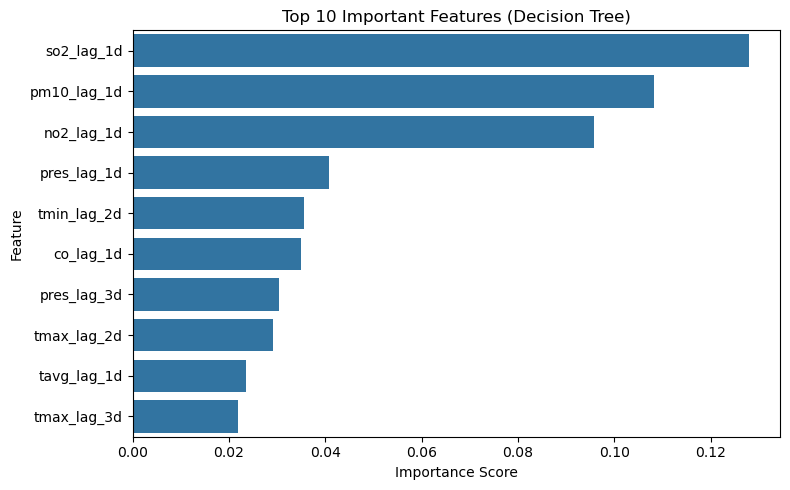

In [97]:
importances = dt_regressor.feature_importances_
# feature_names = X_train.columns

# Get top 10 features
indices = np.argsort(importances)[::-1][:10]
top_features = [(feature_names[i], importances[i]) for i in indices]

print("Top 10 important features for Decision Tree:")
for name, score in top_features:
    print(f"{name}: {score:.4f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[score for _, score in top_features], y=[name for name, _ in top_features])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (Decision Tree)")
plt.tight_layout()
plt.show()

### Random Forest

In [98]:
rf_regressor = RandomForestRegressor()
rf_regressor.fit(X_flat_train, y_flat_train)

RandomForestRegressor()

In [99]:
y_pred = rf_regressor.predict(X_flat_test)

In [100]:
evaluate_predictions(y_true=y_flat_test, y_pred=y_pred, window_size=prediction_window_size)

Day 1:
Metrics for Output 1 (pm25):
  MAE: 0.3840
  MSE: 0.2654
  RMSE: 0.5151
  R2 Score: 0.5328
--------------------
Metrics for Output 2 (pm10):
  MAE: 0.4552
  MSE: 0.3173
  RMSE: 0.5633
  R2 Score: 0.1686
--------------------
Metrics for Output 3 (no2):
  MAE: 0.4315
  MSE: 0.3152
  RMSE: 0.5615
  R2 Score: -0.1619
--------------------
Metrics for Output 4 (so2):
  MAE: 0.2808
  MSE: 0.1444
  RMSE: 0.3800
  R2 Score: 0.5103
--------------------
Metrics for Output 5 (co):
  MAE: 0.7942
  MSE: 0.6983
  RMSE: 0.8356
  R2 Score: -12.0566
--------------------
Day 2:
Metrics for Output 1 (pm25):
  MAE: 0.2808
  MSE: 0.1444
  RMSE: 0.3800
  R2 Score: 0.5103
--------------------
Metrics for Output 2 (pm10):
  MAE: 0.7942
  MSE: 0.6983
  RMSE: 0.8356
  R2 Score: -12.0566
--------------------
Metrics for Output 3 (no2):
  MAE: 0.5352
  MSE: 0.4912
  RMSE: 0.7008
  R2 Score: 0.1341
--------------------
Metrics for Output 4 (so2):
  MAE: 0.5375
  MSE: 0.4663
  RMSE: 0.6829
  R2 Score: -0.2225

Top 10 important features for Random Forest:
so2_lag_1d: 0.1203
pm10_lag_1d: 0.1184
tmin_lag_1d: 0.0462
no2_lag_1d: 0.0419
tavg_lag_1d: 0.0364
pres_lag_1d: 0.0345
co_lag_1d: 0.0305
tmax_lag_1d: 0.0252
tavg_lag_2d: 0.0228
tmax_lag_2d: 0.0207


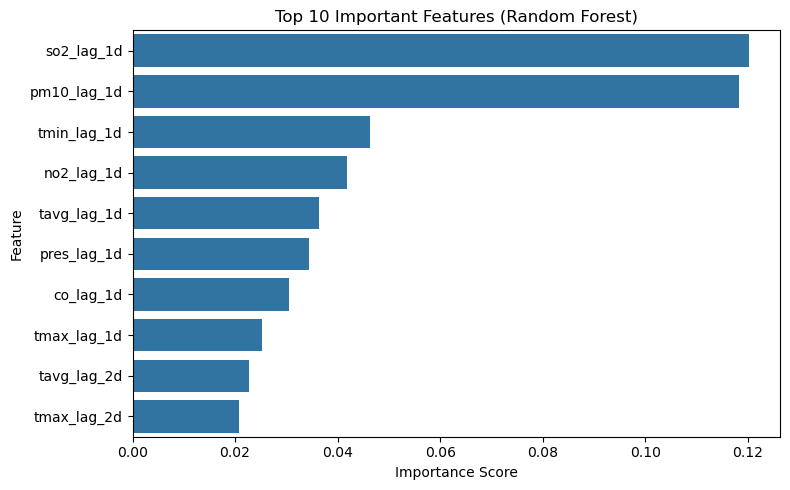

In [101]:
importances = rf_regressor.feature_importances_
# feature_names = X_train.columns

# Get top 10 features
indices = np.argsort(importances)[::-1][:10]
top_features = [(feature_names[i], importances[i]) for i in indices]

print("Top 10 important features for Random Forest:")
for name, score in top_features:
    print(f"{name}: {score:.4f}")

plt.figure(figsize=(8, 5))
sns.barplot(x=[score for _, score in top_features], y=[name for name, _ in top_features])
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.title("Top 10 Important Features (Random Forest)")
plt.tight_layout()
plt.show()

### XGBoost

In [102]:
base_regressor = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

multi_regressor = MultiOutputRegressor(base_regressor)
multi_regressor.fit(X_flat_train, y_flat_train)


MultiOutputRegressor(estimator=XGBRegressor(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.8, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            feature_weights=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=0.1, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=6,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=100, n_jobs=-1,
                                            num_parallel_tree=None, ...))

In [103]:
y_pred = multi_regressor.predict(X_flat_test)

In [104]:
evaluate_predictions(y_true=y_flat_test, y_pred=y_pred, window_size=prediction_window_size)

Day 1:
Metrics for Output 1 (pm25):
  MAE: 0.2726
  MSE: 0.1828
  RMSE: 0.4276
  R2 Score: 0.6781
--------------------
Metrics for Output 2 (pm10):
  MAE: 0.4073
  MSE: 0.2701
  RMSE: 0.5197
  R2 Score: 0.2922
--------------------
Metrics for Output 3 (no2):
  MAE: 0.3495
  MSE: 0.1910
  RMSE: 0.4370
  R2 Score: 0.2960
--------------------
Metrics for Output 4 (so2):
  MAE: 0.2695
  MSE: 0.1368
  RMSE: 0.3698
  R2 Score: 0.5362
--------------------
Metrics for Output 5 (co):
  MAE: 0.5509
  MSE: 0.3538
  RMSE: 0.5949
  R2 Score: -5.6162
--------------------
Day 2:
Metrics for Output 1 (pm25):
  MAE: 0.2695
  MSE: 0.1368
  RMSE: 0.3698
  R2 Score: 0.5362
--------------------
Metrics for Output 2 (pm10):
  MAE: 0.5509
  MSE: 0.3538
  RMSE: 0.5949
  R2 Score: -5.6162
--------------------
Metrics for Output 3 (no2):
  MAE: 0.5313
  MSE: 0.4419
  RMSE: 0.6648
  R2 Score: 0.2210
--------------------
Metrics for Output 4 (so2):
  MAE: 0.5167
  MSE: 0.4136
  RMSE: 0.6431
  R2 Score: -0.0843
--

In [105]:
# Extract feature importance from each target model
importance_df = pd.DataFrame()

for i, target_name in enumerate(target_columns):  # Replace with your target names
    estimator = multi_regressor.estimators_[i]
    importance_df[target_name] = estimator.feature_importances_

# Set feature names as index
importance_df.index = feature_names  # Set index to feature names

# Display top features for each target
for target in importance_df.columns:
    print(f"\n{target} - Top 10 Features:")
    target_imp = importance_df[target].sort_values(ascending=False).head(10)
    for i, (feat, score) in enumerate(target_imp.items()):
        print(f"{i+1:2d}. {feat:<20} : {score:.4f}")

# Overall top features (averaged across all targets)
overall_top = importance_df.mean(axis=1).sort_values(ascending=False).head(10)
print(f"\nOverall Top 10 Features:")
for i, (feat, score) in enumerate(overall_top.items()):
    print(f"{i+1:2d}. {feat:<20} : {score:.4f}")


pm25 - Top 10 Features:
 1. pm10_lag_1d          : 0.2925
 2. pm25_lag_1d          : 0.2169
 3. no2_lag_1d           : 0.0714
 4. tmax_lag_1d          : 0.0263
 5. month_lag_1d         : 0.0245
 6. month_lag_2d         : 0.0237
 7. pres_lag_1d          : 0.0190
 8. day_of_year_lag_1d   : 0.0158
 9. tmax_lag_2d          : 0.0148
10. pm10_lag_2d          : 0.0144

pm10 - Top 10 Features:
 1. pm10_lag_1d          : 0.1402
 2. no2_lag_1d           : 0.0449
 3. pm10_lag_2d          : 0.0417
 4. pm25_lag_1d          : 0.0306
 5. pres_lag_1d          : 0.0293
 6. is_working_day_lag_2d : 0.0275
 7. pm25_lag_2d          : 0.0255
 8. day_of_year_lag_1d   : 0.0245
 9. day_of_week_lag_3d   : 0.0232
10. no2_lag_2d           : 0.0222

no2 - Top 10 Features:
 1. no2_lag_1d           : 0.1859
 2. tavg_lag_1d          : 0.0925
 3. week_of_year_lag_2d  : 0.0588
 4. tmin_lag_1d          : 0.0403
 5. day_of_year_lag_1d   : 0.0315
 6. day_of_year_lag_2d   : 0.0275
 7. tavg_lag_2d          : 0.0260
 8. tmi

### Neural Networks

In [106]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# import torch.optim as optim

# torch.manual_seed(42)

# lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3

## Real world prediction

In [108]:
# Take last {historical_window_size} items for {prediction_window_size} predictions 
X = merged_df[-historical_window_size:]
X[numerical_features] = X_scaler.transform(X[numerical_features])
# Input expects multiple windows
X_flat = flatten_windows([X])

y_pred = multi_regressor.predict(X_flat)

# Split y_pred into 3 arrays, one for each prediction day
y_pred_split = np.split(y_pred.flatten(), prediction_window_size)

# Create DataFrame for predictions, each row is a prediction day
predictions_df = pd.DataFrame(y_pred_split, columns=target_columns)
predictions_df.loc[:] = y_scaler.inverse_transform(predictions_df)

# Definition of Air Quality Index is maximum value of Individual Air Quality Indexes
predictions_df["aqi"] = predictions_df.max(axis=1)

# Set the index to continue from the last date in merged_df
last_date = merged_df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=prediction_window_size, freq="D")
predictions_df.index = future_dates
print(predictions_df)

                 pm25       pm10       no2       so2        co        aqi
2025-07-22  24.766296  21.286526  7.365942  5.176731  2.863497  24.766296
2025-07-23  39.187206  25.102858  5.820953  3.309843  2.555259  39.187206
2025-07-24  49.272820  17.074417  7.717538  2.974473  4.144958  49.272820


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
